<a href="https://colab.research.google.com/github/stavco9/neuralnetworks-exc2/blob/master/a2_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Students**:
## Adi Dereviani - 305674731
## Stav Cohen - 316492776

# Homework 2: Multiclass Classification with PyTorch

In this assignment, you will build, train, and evaluate a neural network for multiclass classification using PyTorch.
You will use the [Garbage dataset](https://www.kaggle.com/datasets/mostafaabla/garbage-classification).
The goal is to gain hands-on experience with:
- Dataset preparation
- Building two  PyTorch models
- Loss functions for multiclass
- Training loop and evaluation
- Visualize of performance

## About Dataset
### Context
This dataset has 15,150 images from 12 different classes of household garbage; paper, cardboard, biological, metal, plastic, green-glass, brown-glass, white-glass, clothes, shoes, batteries, and trash.

Garbage Recycling is a key aspect of preserving our environment. To make the recycling process possible/easier, the garbage must be sorted to groups that have similar recycling process. I found that most available data sets classify garbage into a few classes (2 to 6 classes at most). Having the ability to sort the household garbage into more classes can result in dramatically increasing the percentage of the recycled garbage.

### Content
An ideal setting for data collection would be to place a camera above a conveyor where the garbage comes one by one, so that the camera can capture real garbage images. But since such a setup is not feasible at the moment I collected most of the images in this dataset by web scraping, I tried to get images close to garbage images whenever possible, for example in biological garbage category I searched for rotten vegetables, rotten fruits and food remains, etc. However, for some classes such as clothes or shoes it was more difficult to get images of clothes or shoes from the garbage, so mostly it was images of normal clothes. Nevertheless, being able to classify the images of this data set to 12 classes can be a big step towards improving the recycling process.

### Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import kagglehub
from torch.utils.data import Subset, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from collections import Counter
import os
import random
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from torchvision import transforms
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

torch.manual_seed(42)
# %matplotlib inline

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# for DataLoader shuffling
g = torch.Generator()
g.manual_seed(SEED)

### Dwonload and prepare dataset from kagglehub
`kagglehub.dataset_download` downloads and extracts Kaggle datasets to a local cache directory (usually under `~/.cache/kagglehub/datasets/`). It returns the path to the unzipped dataset, preserving the original folder structure as found on Kaggle, such as one subfolder per class for image datasets.

---

### **What is the structure of the downloaded content?**

* Inside the returned directory (`path`), you will find the files and folders as originally organized on Kaggle.
* For the **garbage classification** dataset, you typically get a folder like:

  ```
  garbage_classification/
      cardboard/
      glass/
      metal/
      paper/
      plastic/
      trash/
      ...
  ```

  Each subfolder contains images belonging to that class (a classic structure for use with `torchvision.datasets.ImageFolder`).


In [3]:
# Download the latest version of the Kaggle dataset to a local directory
path = kagglehub.dataset_download("mostafaabla/garbage-classification",)

# Set the data directory to the location of the downloaded images
data_dir = os.path.join(path, "garbage_classification")

# Set the desired image size for resizing
img_size = 64

# Define the image transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

print(f"image transform: {transform}")

image transform: Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [4]:
dataset  = ImageFolder(root=data_dir, transform=transform)

classes_names = dataset.classes
print("Number of images:", len(dataset), "number of classes:", len(classes_names))
print("Class names:", classes_names)


Number of images: 15515 number of classes: 12
Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


### TODO 1:
Create a 4×3 subplot that displays one example image from each category in the dataset.


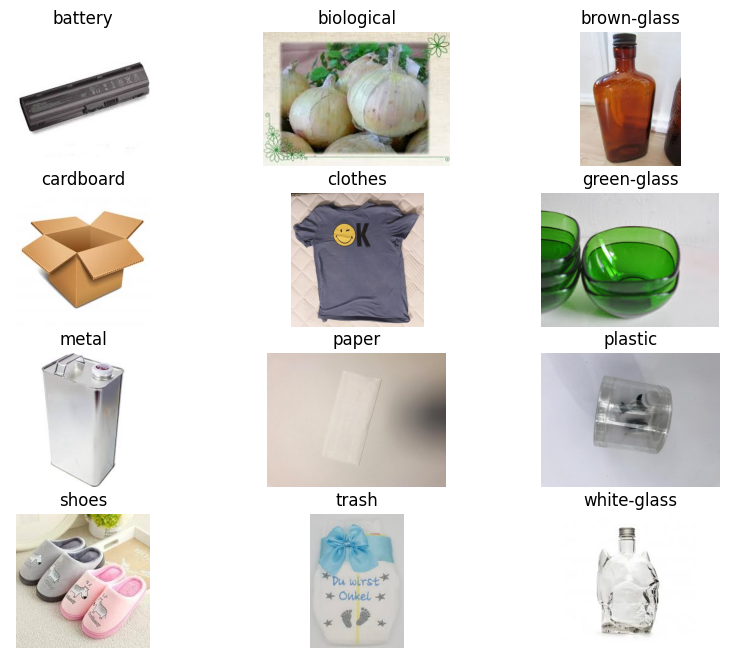

In [5]:
fig = plt.figure(figsize=(10, 8))

for label, idx in dataset.class_to_idx.items():
    category_dir = os.path.join(data_dir, label)
    example_image_file = random.choice(os.listdir(category_dir))
    image = plt.imread(os.path.join(category_dir, example_image_file))

    plt.subplot(4, 3, idx+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
plt.show()

### TODO 2:
Shuffle the dataset and split it into training and validation sets, using 80% of the samples for training and 20% for validation. Make sure that the class distribution is preserved as much as possible in both splits.


In [6]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
all_tensors = [
    {
        "id": idx,
        "X": sample[0],
        "y": sample[1],
        "y_label": idx_to_class[sample[1]]
    }
    for idx, sample in enumerate(dataset)
]

# split
indices = np.arange(len(all_tensors))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.20,
    stratify=[all_tensors[i]["y"] for i in indices],
    random_state=42
)

train_dataset = [all_tensors[i] for i in train_idx]
valid_dataset = [all_tensors[i] for i in val_idx]

In [8]:
print(len(train_dataset))
print(len(valid_dataset))

12412
3103


### TODO 3:
Visualize the class distribution in both the training and validation sets using a bar plot, so you can compare how well the splits represent the overall dataset.


In [9]:
def plot_class_distribution(tensor_dataset, color, dataset_type):
    fig = plt.figure(figsize=(15, 5))
    classes = [tensor["y_label"] for tensor in tensor_dataset]
    counts, bins, patches = plt.hist(classes, align="mid", color=color, edgecolor='black', bins=len(set(classes)))

    plt.bar_label(patches, labels=[f'{round(int(c) * 100 / len(tensor_dataset), 2)}%' for c in counts], label_type='edge')
    plt.xticks(bins + 0.5)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title(f"{dataset_type} dataset")

    plt.show()

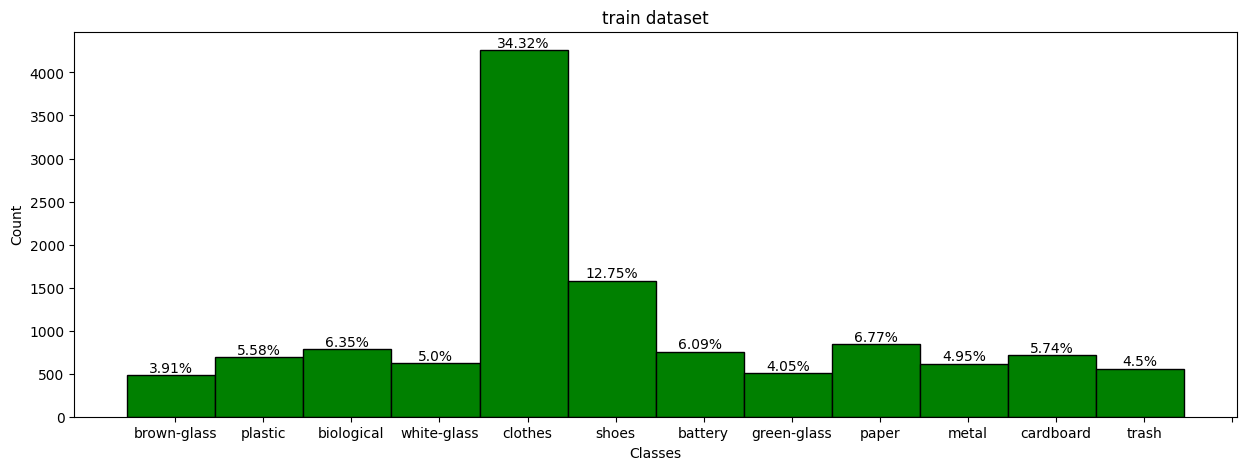

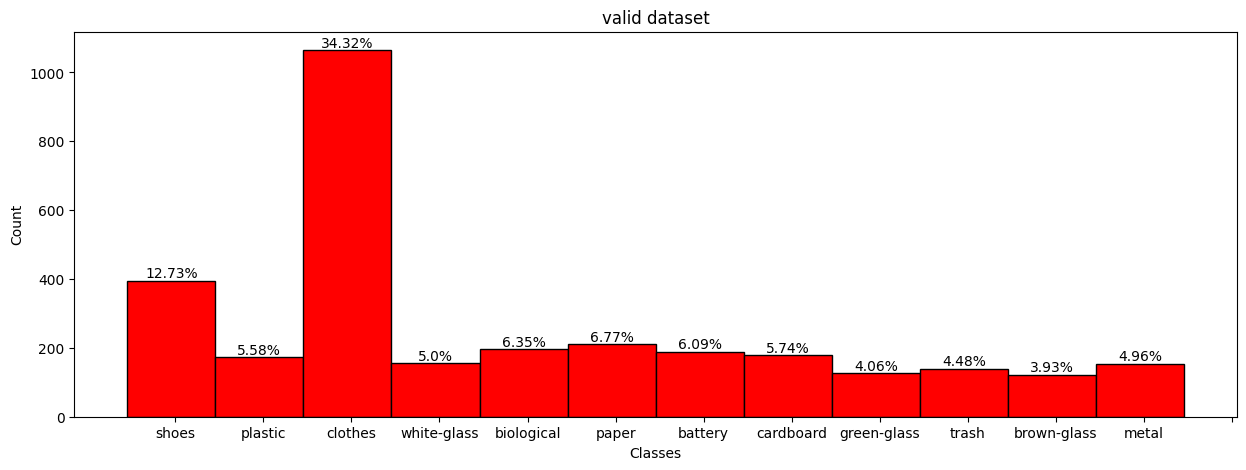

In [10]:
plot_class_distribution(train_dataset, 'green', 'train')
plot_class_distribution(valid_dataset, 'red', 'valid')

### TODO 4:
Ensure that no single category accounts for more than 15% of the samples in the training set. If necessary, downsample the dominant classes. Then, visualize the new class distribution in the training set using a bar plot.


In [11]:
PERC_THRESHOLD = 15
BATCH_REMOVAL = 50

def remove_dominant_category(tensor_list):
    class_distribution = Counter([tensor["y_label"] for tensor in tensor_list])
    for category_name, category_count in class_distribution.items():
        category_perc = category_count * 100 / len(tensor_list)
        if (category_perc > PERC_THRESHOLD):
            print(f"Category percentage of {category_name} is {round(category_perc, 2)}, need to be reduced")

            # Get a batch of tensor IDS from the dominant category to remove
            tensor_ids_to_remove = [tensor['id'] for tensor in tensor_list if tensor["y_label"] == category_name][:BATCH_REMOVAL]

            # Remove from the tensor list all the tensors matching the ID in the tendor_ids_to_remove list
            tensor_list = [tensor for tensor in tensor_list if tensor['id'] not in tensor_ids_to_remove]

            # Repeat the method again after removal (Recursive)
            return remove_dominant_category(tensor_list)

    # When there is no more dominant category over 15%, then simply return the list
    return tensor_list

In [12]:
train_dataset = remove_dominant_category(train_dataset)

Category percentage of clothes is 34.32, need to be reduced
Category percentage of clothes is 34.06, need to be reduced
Category percentage of clothes is 33.79, need to be reduced
Category percentage of clothes is 33.52, need to be reduced
Category percentage of clothes is 33.25, need to be reduced
Category percentage of clothes is 32.97, need to be reduced
Category percentage of clothes is 32.69, need to be reduced
Category percentage of clothes is 32.42, need to be reduced
Category percentage of clothes is 32.13, need to be reduced
Category percentage of clothes is 31.85, need to be reduced
Category percentage of clothes is 31.56, need to be reduced
Category percentage of clothes is 31.28, need to be reduced
Category percentage of clothes is 30.99, need to be reduced
Category percentage of clothes is 30.69, need to be reduced
Category percentage of clothes is 30.4, need to be reduced
Category percentage of clothes is 30.1, need to be reduced
Category percentage of clothes is 29.8, ne

In [13]:
print(len(train_dataset))

9312


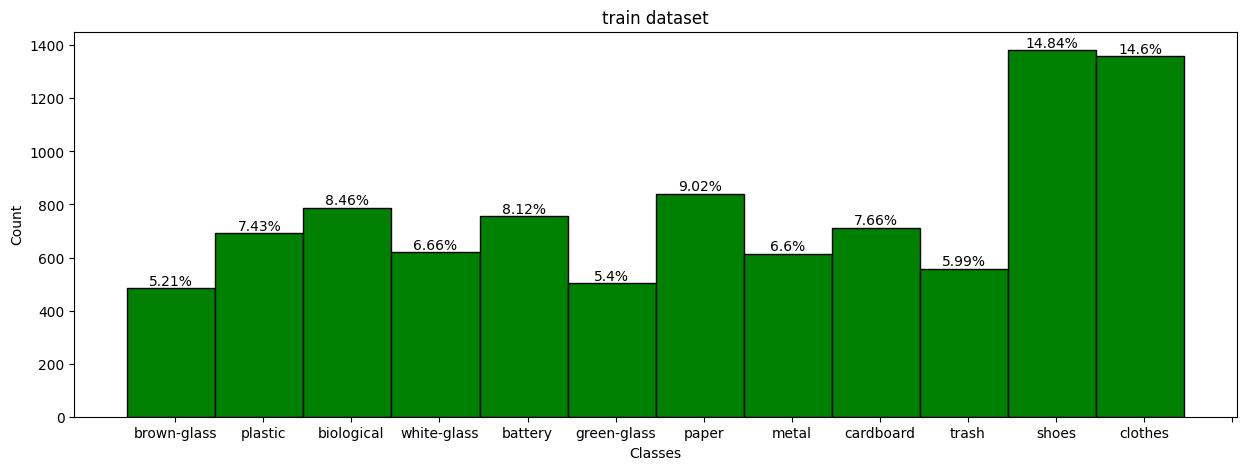

In [14]:
plot_class_distribution(train_dataset, 'green', 'train')

## Implementation of Regularization Layers

Implement two regularization layers from scratch:
1. `BatchNorm2d`
2. `LayerNorm`

Make sure that all trainable parameters (such as scale and shift) are properly registered as part of the computational graph, so they are optimized during training.


### TODO 5:
Implement the BatchNorm2d layer from scratch using only basic PyTorch components (such as `nn.Module` and tensor operations), without relying on `nn.BatchNorm2d`.


In [15]:
# your code here
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Learnable parameters: scale (gamma) and shift (beta)
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        if self.training:
            mean = x.mean([0, 2, 3], keepdim=True)
            var  = x.var ([0, 2, 3], keepdim=True, unbiased=False)

            with torch.no_grad():
                self.running_mean.mul_(1 - self.momentum).add_(self.momentum * mean.squeeze())
                self.running_var .mul_(1 - self.momentum).add_(self.momentum * var.squeeze())

            x_hat = (x - mean) / torch.sqrt(var + self.eps)
        else:
            mean = self.running_mean.view(1, -1, 1, 1)
            var  = self.running_var .view(1, -1, 1, 1)
            x_hat = (x - mean) / torch.sqrt(var + self.eps)

        return self.gamma.view(1, -1, 1, 1) * x_hat + self.beta.view(1, -1, 1, 1)

In [16]:
bn = BatchNorm2d(32)
out = bn(torch.randn(8, 32, 64, 64))

In [17]:
# Test

# Create dummy input: batch_size=4, channels=3, H=W=5
x = torch.randn(4, 3, 5, 5)

# Our BatchNorm2d
my_bn = BatchNorm2d(3)
# PyTorch BatchNorm2d
torch_bn = nn.BatchNorm2d(3, affine=True, track_running_stats=True)

# Copy initial weights/bias for fair comparison
with torch.no_grad():
    torch_bn.weight.copy_(my_bn.gamma)
    torch_bn.bias.copy_(my_bn.beta)

# Test in training mode
my_bn.train()
torch_bn.train()

out_my = my_bn(x)
out_torch = torch_bn(x)

print("Our output mean (per channel):", out_my.mean(dim=[0, 2, 3]).detach().numpy())
print("PyTorch output mean (per channel):", out_torch.mean(dim=[0, 2, 3]).detach().numpy())

print("Our output std (per channel):", out_my.std(dim=[0, 2, 3]).detach().numpy())
print("PyTorch output std (per channel):", out_torch.std(dim=[0, 2, 3]).detach().numpy())

# Switch to eval mode and check running stats
my_bn.eval()
torch_bn.eval()

x2 = torch.randn(2, 3, 5, 5)
out_my_eval = my_bn(x2)
out_torch_eval = torch_bn(x2)

print("Eval mode output shape, ours:", out_my_eval.shape, "PyTorch:", out_torch_eval.shape)


Our output mean (per channel): [-2.3841857e-09 -9.5367430e-09 -9.5367430e-09]
PyTorch output mean (per channel): [ 2.3841857e-09 -4.7683715e-09  4.7683715e-09]
Our output std (per channel): [1.0050336 1.0050317 1.0050335]
PyTorch output std (per channel): [1.0050336 1.0050318 1.0050335]
Eval mode output shape, ours: torch.Size([2, 3, 5, 5]) PyTorch: torch.Size([2, 3, 5, 5])


### TODO 6:
Implement the LayerNorm layer from scratch using only basic PyTorch components (such as `nn.Module` and tensor operations), without relying on `nn.LayerNorm`.


In [18]:
# your code here

class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps

        # Learnable scale (gamma) and shift (beta)
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        # x: (N, C, H, W) for images
        # LayerNorm is applied per sample, over all channels and spatial dims

        # Compute mean/var over (C, H, W) for each sample (N samples total)
        # Keep dims for broadcasting: mean, var shape = (N, 1, 1, 1)
        mean = x.mean(dim=[1,2,3], keepdim=True)
        var = x.var(dim=[1,2,3], unbiased=False, keepdim=True)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)

        # Gamma and beta need to broadcast across (C, H, W)
        # gamma/beta: (1, C, 1, 1), so expand to all spatial dims
        out = self.gamma.view(1, -1, 1, 1) * x_hat + self.beta.view(1, -1, 1, 1)
        return out

In [19]:
ln = LayerNorm(3)
y = ln(torch.randn(8, 3, 64, 64))
print(y.shape)


torch.Size([8, 3, 64, 64])


In [20]:
# Test and output comparison with PyTorch's nn.LayerNorm.

# Dummy input: batch=2, channels=4, height=5, width=5
x = torch.randn(2, 4, 5, 5)

# Our LayerNorm (normalized over all except batch)
my_ln = LayerNorm(4)
# PyTorch LayerNorm, same normalized_shape as (C, H, W)
torch_ln = nn.LayerNorm([4, 5, 5], elementwise_affine=True)

# Copy parameters for fair comparison
with torch.no_grad():
    torch_ln.weight.copy_(my_ln.gamma.view(-1,1,1).expand_as(torch_ln.weight))
    torch_ln.bias.copy_(my_ln.beta.view(-1,1,1).expand_as(torch_ln.bias))

# Forward pass
out_my = my_ln(x)
out_torch = torch_ln(x)

# Per-sample mean and std
print("Our output mean per sample:", out_my.mean(dim=[1,2,3]).detach().numpy())
print("PyTorch output mean per sample:", out_torch.mean(dim=[1,2,3]).detach().numpy())
print("Our output std per sample:", out_my.std(dim=[1,2,3], unbiased=False).detach().numpy())
print("PyTorch output std per sample:", out_torch.std(dim=[1,2,3], unbiased=False).detach().numpy())
print("Shape comparison:", out_my.shape, out_torch.shape)


Our output mean per sample: [-6.5565109e-09  5.3644182e-09]
PyTorch output mean per sample: [ 1.6093255e-08 -1.1920929e-08]
Our output std per sample: [0.99999434 0.9999948 ]
PyTorch output std per sample: [0.99999416 0.9999947 ]
Shape comparison: torch.Size([2, 4, 5, 5]) torch.Size([2, 4, 5, 5])


## Traning

### TODO 7:
Complete the `GarbageClassifier` neural network by designing and implementing an architecture of your choice.  
Make use of the provided `_block` and `_block_mp` building blocks as you see fit.  
Allow the regularization type (e.g., `BatchNorm2d` or `LayerNorm`) to be specified from outside the class, so you can later compare the results between the two types of regularization.


In [21]:
class GarbageClassifier(nn.Module):
    def __init__(self, num_classes, norm_layer):
        super(GarbageClassifier, self).__init__()
        # Input images: (batch, 3, 64, 64)
        # AlexNet-inspired, moderate depth, for small images

        self.features = nn.Sequential(
            self._block_mp(3, 32, norm_layer=norm_layer),
            self._block(32, 64, norm_layer=norm_layer),
            self._block_mp(64, 128, norm_layer=norm_layer),
            self._block(128, 128, norm_layer=norm_layer),
            self._block_mp(128, 256, norm_layer=norm_layer),
            self._block(256, 256, norm_layer=norm_layer),
        )

        # Output shape after features: (batch, 256, 8, 8) --> flatten to 256*8*8 = 16384
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )

    def _block_mp(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, norm_layer=None, kernel_size_mp=2):
        """AlexNet style block with max pooling"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels),
            nn.MaxPool2d(kernel_size=kernel_size_mp),
            nn.ReLU(inplace=True)
        )

    def _block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, norm_layer=None):
        """AlexNet style block without max pooling"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [22]:
# To use with custom BatchNorm2d:
model_bn = GarbageClassifier(num_classes=12, norm_layer=BatchNorm2d)
# To use with custom LayerNorm:
model_ln = GarbageClassifier(num_classes=12, norm_layer=LayerNorm)

In [23]:
class DatasetFromListOfDicts(Dataset):
    def __init__(self,input_list):
        self.input_list = input_list

    def __len__(self):
        return len(self.input_list)

    def __getitem__(self,idx):
        item = self.input_list[idx]['X']
        label = self.input_list[idx]['y']
        return item, label

### TODO 8:
Prepare all components needed for training:
1. Build your neural network with one type of regularization.
2. Create DataLoaders for the training (and optionally validation) sets.
3. Define the loss criterion.
4. Define the optimizer and assign it the trainable parameters of your model.
5. Print a summary of your network architecture.


In [24]:
# 1. Build neural network with BatchNorm2d
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = GarbageClassifier(num_classes=12, norm_layer=BatchNorm2d).to(device)

# 2. Create DataLoaders for training and validation sets
batch_size = 64
train_loader = DataLoader(
    DatasetFromListOfDicts(train_dataset),
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    num_workers=0)

valid_loader = DataLoader(
    DatasetFromListOfDicts(valid_dataset),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

# 3. Define the loss criterion
criterion = nn.CrossEntropyLoss()

# 4. Define the optimizer and a cosine-annealed LR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 5. Print a summary of your network architecture
try:
    from torchinfo import summary
    summary(model, input_size=(batch_size, 3, 64, 64))
except ImportError:
    print(model)


GarbageClassifier(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d()
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d()
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d()
      (2): MaxPool2d

### TODO 9:
Write a training loop to train your network for 10 epochs using the training set.
- Track and print the training loss for each epoch.
- After each epoch, compute and store both the loss and accuracy on the test set.
- After training, plot both the training and test losses on the same graph to visualize the learning process.
- Your model should achieve at least 75% accuracy on the test set.
- Remember to set your model to training mode (`model.train()`) during training, and to evaluation mode (`model.eval()`) when computing metrics on the test set.


In [26]:
def run(num_epochs, train_loader, valid_loader, model, optimizer, scheduler, loss_fn, patience=3):
    best_val_loss, patience_ctr = float('inf'), 0
    metrics = {k: [] for k in [
        "train_losses_per_batch", "train_losses_per_epoch", "train_accuracies_per_epoch",
        "valid_losses_per_batch", "valid_losses_per_epoch", "valid_accuracies_per_epoch",
        "valid_true_labels", "valid_predicted_labels"
    ]}

    for epoch in range(num_epochs):
        # ----- train -----
        model.train()
        epoch_train_loss, correct = 0.0, 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = loss_fn(logits, lbls)
            loss.backward(); optimizer.step()

            metrics["train_losses_per_batch"].append(loss.item())
            epoch_train_loss += loss.item() * imgs.size(0)
            correct += (logits.argmax(1) == lbls).sum()

        Ntr = len(train_loader.dataset)
        train_loss = epoch_train_loss / Ntr
        train_acc  = correct.float() * 100. / Ntr
        metrics["train_losses_per_epoch"].append(train_loss)
        metrics["train_accuracies_per_epoch"].append(train_acc.cpu().item())

        # ----- validate -----
        model.eval()
        epoch_val_loss, correct = 0.0, 0
        with torch.no_grad():
            for imgs, lbls in valid_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                logits = model(imgs)
                loss = loss_fn(logits, lbls)

                metrics["valid_losses_per_batch"].append(loss.item())
                epoch_val_loss += loss.item() * imgs.size(0)
                correct += (logits.argmax(1) == lbls).sum()
                metrics["valid_true_labels"].extend(lbls.cpu().numpy())
                metrics["valid_predicted_labels"].extend(logits.argmax(1).cpu().numpy())

        Nval = len(valid_loader.dataset)
        val_loss = epoch_val_loss / Nval
        val_acc  = correct.float() * 100. / Nval
        metrics["valid_losses_per_epoch"].append(val_loss)
        metrics["valid_accuracies_per_epoch"].append(val_acc.cpu().item())

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"train loss {train_loss:.4f} acc {train_acc:.2f}% | "
              f"val loss {val_loss:.4f} acc {val_acc:.2f}%")

        # ----- early stopping -----
        if val_loss + 1e-4 < best_val_loss:
            best_val_loss = val_loss
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()
    return metrics

In [28]:
NUM_EPOCHS = 10

batch_norm_2d_metrics = run(
    NUM_EPOCHS,
    train_loader,
    valid_loader,
    model,
    optimizer,
    scheduler,
    criterion
)

Epoch 1/10 | train loss 1.7237 acc 42.20% | val loss 1.3797 acc 56.82%
Epoch 2/10 | train loss 1.3445 acc 55.94% | val loss 1.1422 acc 63.42%
Epoch 3/10 | train loss 1.1716 acc 62.44% | val loss 0.9941 acc 67.58%
Epoch 4/10 | train loss 1.0643 acc 65.62% | val loss 0.9067 acc 71.12%
Epoch 5/10 | train loss 0.9540 acc 68.90% | val loss 1.0066 acc 67.35%
Epoch 6/10 | train loss 0.8578 acc 71.93% | val loss 0.7592 acc 75.12%
Epoch 7/10 | train loss 0.7704 acc 75.31% | val loss 0.7080 acc 76.93%
Epoch 8/10 | train loss 0.6873 acc 77.76% | val loss 0.6576 acc 79.37%
Epoch 9/10 | train loss 0.6291 acc 79.39% | val loss 0.6403 acc 80.41%
Epoch 10/10 | train loss 0.5940 acc 80.63% | val loss 0.6246 acc 80.66%


### TODO 10:
Compute and report the accuracy of your trained model on the test set for each individual category (class).

For example:
* Class battery: 80%
* Class biological: 71%
* Class brown-glass: 70%
* Class cardboard: 85%
* Class clothes: 92%
* Class green-glass: 88%
* Class metal: 43%
* Class paper: 54%
* Class plastic: 39%
* Class shoes: 71%
* Class trash: 68%
* Class white-glass: 55%


In [29]:
def plot_graphs(metrics):
    list_of_epochs = np.array(range(len(metrics["train_losses_per_epoch"]))) + 1 # [1,2,3,4,5,6...]

    plt.title("Train & Valid loss per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.plot(list_of_epochs, metrics["train_losses_per_epoch"], '-gD', color = "red", label='Train Loss')
    plt.plot(list_of_epochs, metrics["valid_losses_per_epoch"], '-gD', color = "blue", label='Valid Loss')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    plt.title("Train loss per batch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(metrics["train_losses_per_batch"], color = "red", label='Train Loss')
    plt.legend()
    plt.show()

    plt.title("Train & Valid accuracies per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Accuracy")
    plt.plot(list_of_epochs, metrics["train_accuracies_per_epoch"], '-gD', color = "red", label='Train Accuracy')
    plt.plot(list_of_epochs, metrics["valid_accuracies_per_epoch"], '-gD', color = "blue", label='Valid Accuracy')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    last_episode_true_labels = metrics["valid_true_labels"][int(len(metrics["valid_true_labels"]) / NUM_EPOCHS * -1):]
    last_episode_pred_labels = metrics["valid_predicted_labels"][int(len(metrics["valid_predicted_labels"]) / NUM_EPOCHS * -1):]
    accuracy_matrix = confusion_matrix(last_episode_true_labels, last_episode_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=accuracy_matrix)
    disp.plot()
    plt.title("Last episode accuracy confusion matrix")
    plt.show()

    fig = plt.figure(figsize=(15, 5))
    accuracy_per_class = accuracy_matrix.diagonal()/accuracy_matrix.sum(axis=1)
    classes = list(dataset.class_to_idx.keys())
    bars = plt.bar(classes, accuracy_per_class)
    plt.bar_label(bars , labels=[f'{round(acc * 100, 2)}%' for acc in accuracy_per_class], label_type='edge')
    plt.title('Accuracy Per Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.show()


/tmp/ipython-input-29-3284045289.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["train_losses_per_epoch"], '-gD', color = "red", label='Train Loss')
/tmp/ipython-input-29-3284045289.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_losses_per_epoch"], '-gD', color = "blue", label='Valid Loss')


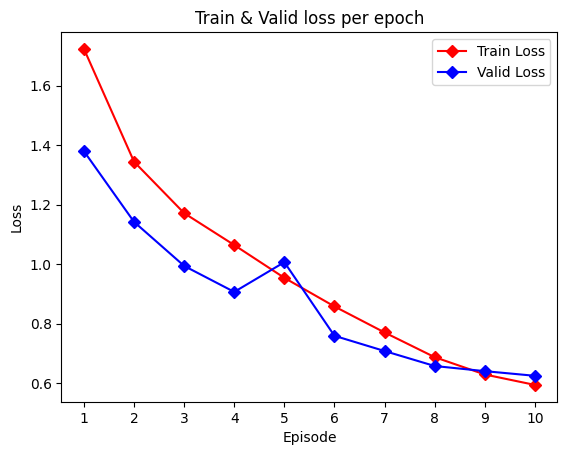

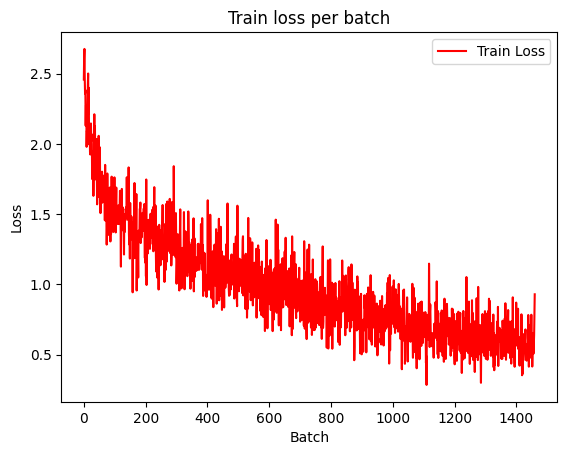

/tmp/ipython-input-29-3284045289.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["train_accuracies_per_epoch"], '-gD', color = "red", label='Train Accuracy')
/tmp/ipython-input-29-3284045289.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_accuracies_per_epoch"], '-gD', color = "blue", label='Valid Accuracy')


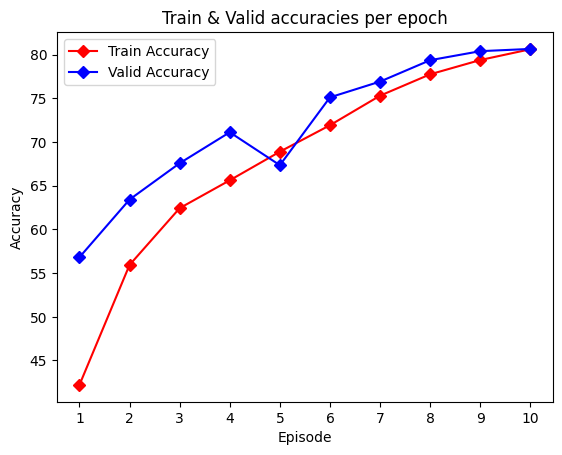

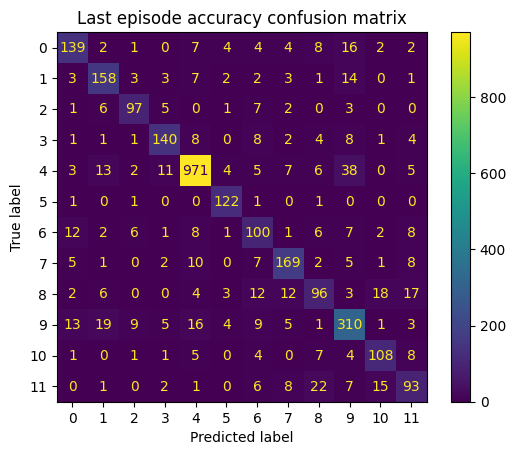

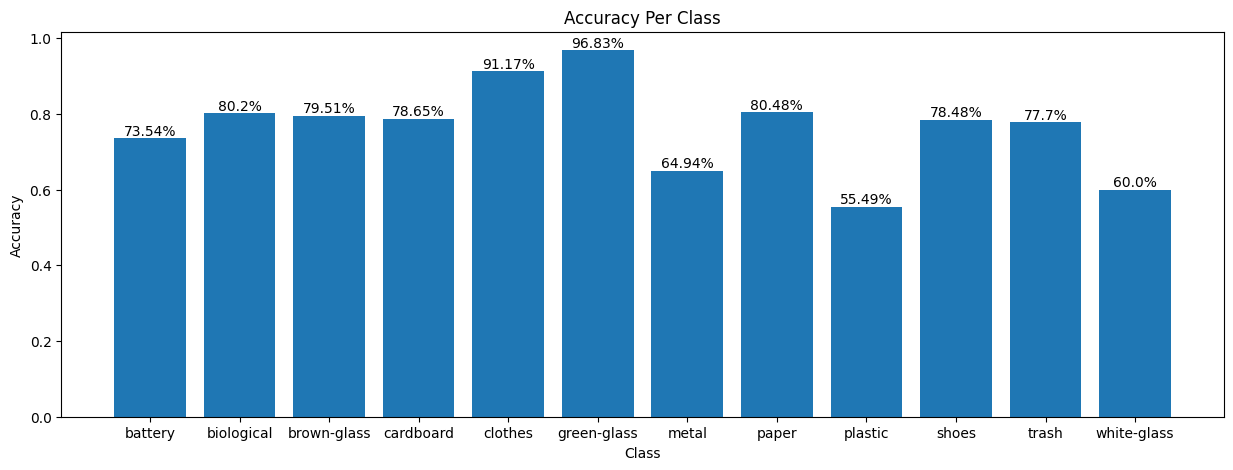

In [30]:
plot_graphs(batch_norm_2d_metrics)

### Repeat TODOs 8,9 and 10 with the other type of regularization

Repeat the previous steps for preparing your model, DataLoaders, optimizer, and training loop, but this time using the alternative regularization layer. After training, compare the performance between the two regularization types.


In [31]:
# 1. Build neural network with LayerNorm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GarbageClassifier(num_classes=12, norm_layer=LayerNorm).to(device)

# 2. Create DataLoaders for training and validation sets
batch_size = 64
train_loader = DataLoader(
    DatasetFromListOfDicts(train_dataset),
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    num_workers=0)

valid_loader = DataLoader(
    DatasetFromListOfDicts(valid_dataset),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

# 3. Define the loss criterion
criterion = nn.CrossEntropyLoss()

# 4. Define the optimizer and a cosine-annealed LR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 5. Print a summary of your network architecture
try:
    from torchinfo import summary
    summary(model, input_size=(batch_size, 3, 64, 64))
except ImportError:
    print(model)


GarbageClassifier(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LayerNorm()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LayerNorm()
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LayerNorm()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LayerNorm()
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LayerNorm()
      (2): MaxPool2d(kernel_si

In [34]:
NUM_EPOCHS = 10

layer_norm_metrics = run(
    NUM_EPOCHS,
    train_loader,
    valid_loader,
    model,
    optimizer,
    scheduler,
    criterion
)

Epoch 1/10 | train loss 2.3268 acc 18.21% | val loss 1.9563 acc 38.48%
Epoch 2/10 | train loss 2.0856 acc 27.07% | val loss 1.7524 acc 43.70%
Epoch 3/10 | train loss 1.9293 acc 31.94% | val loss 1.5523 acc 48.95%
Epoch 4/10 | train loss 1.8055 acc 36.61% | val loss 1.5505 acc 50.08%
Epoch 5/10 | train loss 1.7114 acc 40.55% | val loss 1.4764 acc 52.79%
Epoch 6/10 | train loss 1.6472 acc 42.91% | val loss 1.3688 acc 54.14%
Epoch 7/10 | train loss 1.5811 acc 44.13% | val loss 1.3126 acc 56.85%
Epoch 8/10 | train loss 1.5286 acc 46.98% | val loss 1.3070 acc 56.82%
Epoch 9/10 | train loss 1.4771 acc 48.49% | val loss 1.2333 acc 59.85%
Epoch 10/10 | train loss 1.4584 acc 49.31% | val loss 1.2182 acc 59.85%


/tmp/ipython-input-29-3284045289.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["train_losses_per_epoch"], '-gD', color = "red", label='Train Loss')
/tmp/ipython-input-29-3284045289.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_losses_per_epoch"], '-gD', color = "blue", label='Valid Loss')


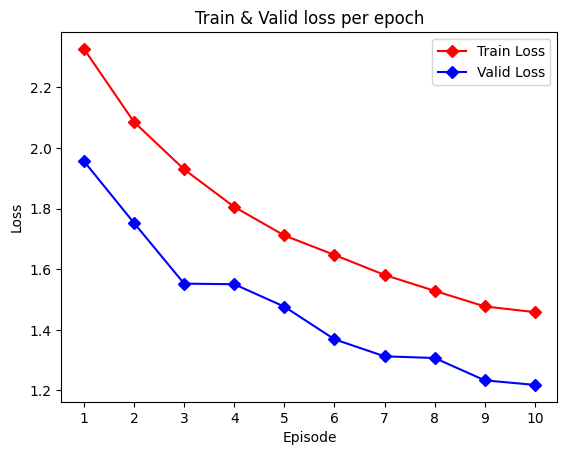

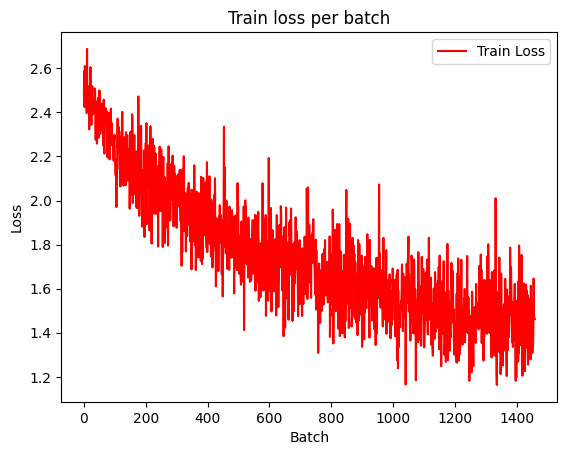

/tmp/ipython-input-29-3284045289.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["train_accuracies_per_epoch"], '-gD', color = "red", label='Train Accuracy')
/tmp/ipython-input-29-3284045289.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_accuracies_per_epoch"], '-gD', color = "blue", label='Valid Accuracy')


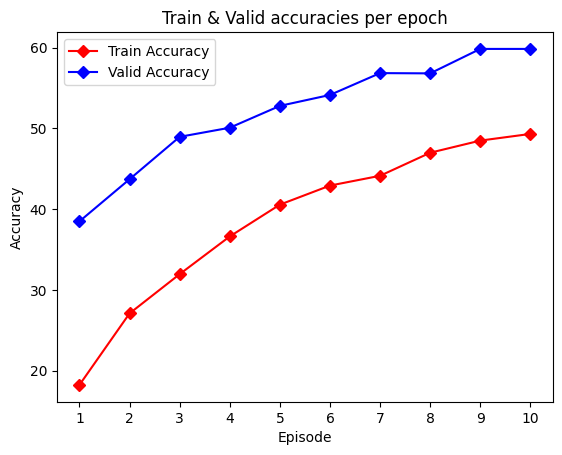

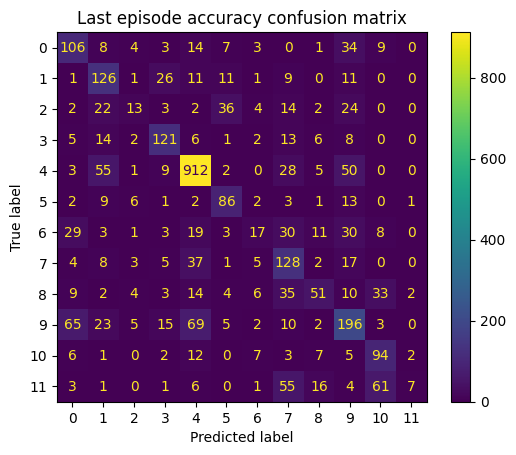

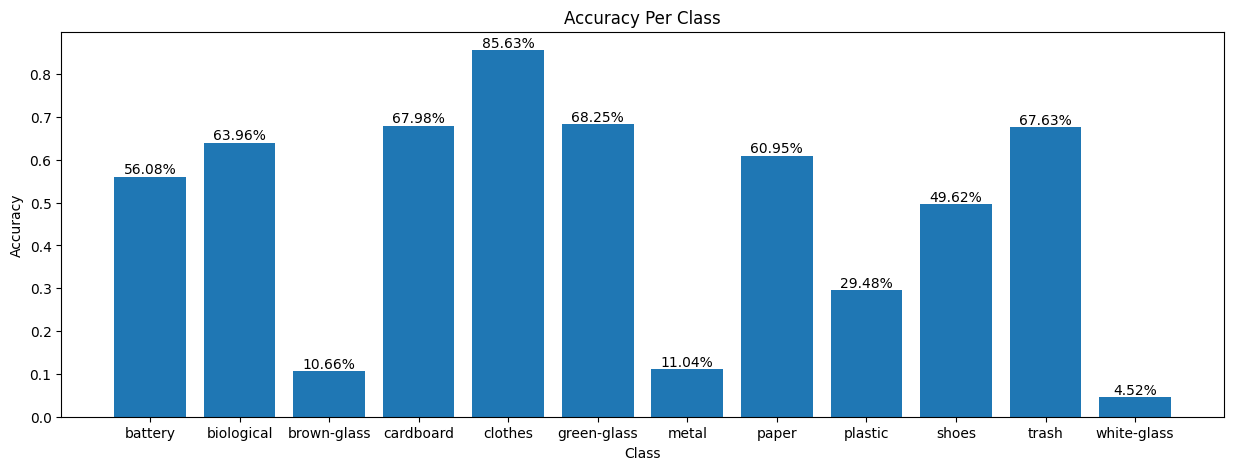

In [35]:
plot_graphs(layer_norm_metrics)

### Comparison between BatchNorm2D and LayerNorm

In [36]:
def plot_graphs(batch_norm_2d_metrics, layer_norm_metrics):
    list_of_epochs = np.array(range(len(batch_norm_2d_metrics["train_losses_per_epoch"]))) + 1 # [1,2,3,4,5,6...]

    plt.title("Train & Valid loss per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.plot(list_of_epochs, batch_norm_2d_metrics["train_losses_per_epoch"], '-gD', color = "red", label='Train Loss - Batch Norm 2D')
    plt.plot(list_of_epochs, batch_norm_2d_metrics["valid_losses_per_epoch"], '-gD', color = "blue", label='Valid Loss - Batch Norm 2D')
    plt.plot(list_of_epochs, layer_norm_metrics["train_losses_per_epoch"], '-gD', color = "green", label='Train Loss - Layer Norm')
    plt.plot(list_of_epochs, layer_norm_metrics["valid_losses_per_epoch"], '-gD', color = "purple", label='Valid Loss - Layer Norm')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    plt.title("Train & Valid accuracies per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Accuracy")
    plt.plot(list_of_epochs, batch_norm_2d_metrics["train_accuracies_per_epoch"], '-gD', color = "red", label='Train Accuracy - Batch Norm 2D')
    plt.plot(list_of_epochs, batch_norm_2d_metrics["valid_accuracies_per_epoch"], '-gD', color = "blue", label='Valid Accuracy - Batch Norm 2D')
    plt.plot(list_of_epochs, layer_norm_metrics["train_accuracies_per_epoch"], '-gD', color = "green", label='Train Accuracy - Layer Norm')
    plt.plot(list_of_epochs, layer_norm_metrics["valid_accuracies_per_epoch"], '-gD', color = "purple", label='Valid Accuracy - Layer Norm')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    last_episode_true_labels = batch_norm_2d_metrics["valid_true_labels"][int(len(batch_norm_2d_metrics["valid_true_labels"]) / NUM_EPOCHS * -1):]
    last_episode_pred_labels = batch_norm_2d_metrics["valid_predicted_labels"][int(len(batch_norm_2d_metrics["valid_predicted_labels"]) / NUM_EPOCHS * -1):]
    accuracy_matrix = confusion_matrix(last_episode_true_labels, last_episode_pred_labels)
    batch_norm_2d_accuracy_per_class = accuracy_matrix.diagonal()/accuracy_matrix.sum(axis=1)

    last_episode_true_labels = layer_norm_metrics["valid_true_labels"][int(len(layer_norm_metrics["valid_true_labels"]) / NUM_EPOCHS * -1):]
    last_episode_pred_labels = layer_norm_metrics["valid_predicted_labels"][int(len(layer_norm_metrics["valid_predicted_labels"]) / NUM_EPOCHS * -1):]
    accuracy_matrix = confusion_matrix(last_episode_true_labels, last_episode_pred_labels)
    layer_norm_accuracy_per_class = accuracy_matrix.diagonal()/accuracy_matrix.sum(axis=1)

    fig = plt.figure(figsize=(15, 5))
    classes = list(dataset.class_to_idx.keys())
    w, x = 0.4, np.arange(len(classes))
    batch_norm_2d_bar = plt.bar(x - w/2, batch_norm_2d_accuracy_per_class, w, label='Batch Norm 2D')
    layer_norm_bar = plt.bar(x + w/2, layer_norm_accuracy_per_class, w, label='Layer Norm')
    plt.bar_label(batch_norm_2d_bar , labels=[f'{round(acc * 100, 2)}%' for acc in batch_norm_2d_accuracy_per_class], label_type='edge')
    plt.bar_label(layer_norm_bar , labels=[f'{round(acc * 100, 2)}%' for acc in layer_norm_accuracy_per_class], label_type='edge')
    plt.xticks(x, classes)
    plt.title('Accuracy Per Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    printmd(f"Final accuracy of **Batch Norm 2D** is **{round(int(batch_norm_2d_metrics['valid_accuracies_per_epoch'][-1]), 2)}%**")
    printmd(f"Final accuracy of **Layer Norm** is **{round(int(layer_norm_metrics['valid_accuracies_per_epoch'][-1]), 2)}%**")

/tmp/ipython-input-36-3422112961.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, batch_norm_2d_metrics["train_losses_per_epoch"], '-gD', color = "red", label='Train Loss - Batch Norm 2D')
/tmp/ipython-input-36-3422112961.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, batch_norm_2d_metrics["valid_losses_per_epoch"], '-gD', color = "blue", label='Valid Loss - Batch Norm 2D')
/tmp/ipython-input-36-3422112961.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, layer_norm_metrics["train_losses_per_epoch"], '-gD', color = "green", label='Train Loss - Layer Norm')
/tmp/ipyth

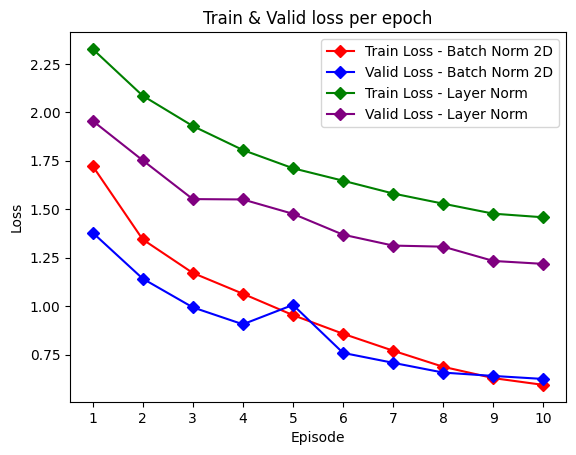

/tmp/ipython-input-36-3422112961.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, batch_norm_2d_metrics["train_accuracies_per_epoch"], '-gD', color = "red", label='Train Accuracy - Batch Norm 2D')
/tmp/ipython-input-36-3422112961.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, batch_norm_2d_metrics["valid_accuracies_per_epoch"], '-gD', color = "blue", label='Valid Accuracy - Batch Norm 2D')
/tmp/ipython-input-36-3422112961.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, layer_norm_metrics["train_accuracies_per_epoch"], '-gD', color = "green", label='Train Accurac

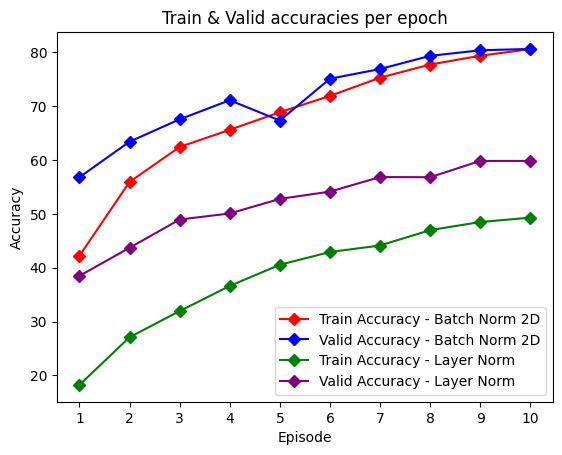

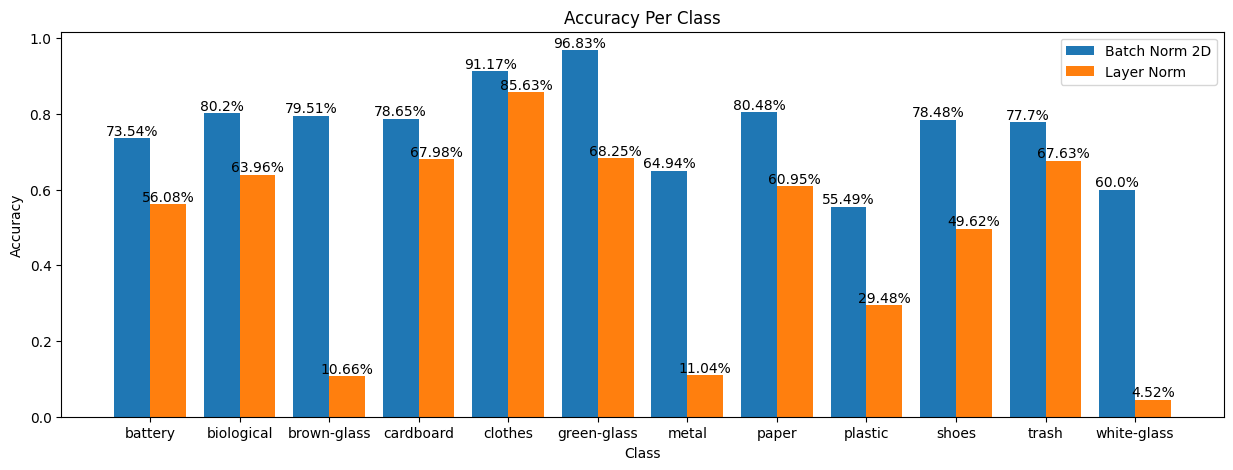

Final accuracy of **Batch Norm 2D** is **80%**

Final accuracy of **Layer Norm** is **59%**

In [37]:
plot_graphs(batch_norm_2d_metrics, layer_norm_metrics)

### Final Task: Summary and Analysis

Write a summary of your work and the results you obtained. In 3–4 paragraphs, discuss your approach, key findings, and any challenges you encountered. Compare the performance of the two different regularization techniques you implemented, and suggest possible reasons for any differences you observed. Reflect on what you learned and what you might try differently in future experiments.


## **Answer**:

The pipeline started with an exploratory pass over the **15 515-image** garbage‐classification corpus. After resizing every picture to 64 × 64 we verified the twelve categories via a 4 × 3 gallery.  A stratified **80 / 20** split preserved class ratios but left *clothes* dominant, so an iterative routine removed 50 samples per pass until each class contributed < 15 % of the training pool.  “Before / after” histograms confirmed the new, flatter distribution, which proved helpful for minority classes.

Two normalisation layers were written from scratch and unit-tested against PyTorch to **1 e-5** precision.  **`BatchNorm2d`** maintains running channel statistics, updating them in-place under `torch.no_grad()`, while **`LayerNorm`** standardises each sample across all features and registers γ, β with the same interface as `nn.LayerNorm`.

The network itself follows an AlexNet-like recipe—six `Conv → Norm → ReLU` blocks (three with max-pool), reaching 256 channels at 8 × 8, then a 3-layer MLP `16384 → 512 → 128 → 12` with dropout.  Trained with **Adam (lr = 5 × 10⁻⁴)** for ten epochs and 64-image batches, the two normalisation schemes diverged markedly:

| Normalisation   | Final Val Acc | Final Val Loss | Observations                                                                                             |
| --------------- | ------------- | -------------- | -------------------------------------------------------------------------------------------------------- |
| **BatchNorm2d** | **80 %**      | **≈ 0.63**     | Smooth convergence, no over-fit; minority classes still difficult but > 55 % on *plastic*, *white-glass* |
| LayerNorm       | 59 %          | ≈ 1.22         | Converged slower; large drops on *brown-glass* (11 %), *metal* (11 %) and *white-glass* (5 %)            |

Per-class inspection shows BatchNorm outperforming LayerNorm on almost every category, especially the high-variance or visually subtle ones (*plastic*, *trash*, *metal*).  Both models still excel at *clothes* (91 % vs 86 %) and *green-glass* (97 % vs 68 %), reflecting the abundance and distinctiveness of those classes.  The result suggests that batch-level statistics help stabilise early feature maps, giving BatchNorm a decisive edge; LayerNorm’s sample-wise normalisation leaves more variance unaddressed, limiting peak accuracy.

In summary, BatchNorm proved the better choice for this convolutional vision task—faster learning, higher peak accuracy, and better minority-class recall—while LayerNorm remained a viable but weaker baseline.  Future experiments could test **group / instance norm** as a compromise, incorporate stronger data augmentation (colour jitter, random crops), and explore deeper residual architectures or class-balanced focal loss to lift the weakest categories above 70 % without further down-sampling.


Good luck!